<h1>MNIST Done Wrong</h1>
<p>The standard approach with MNIST to train a digit classifier using one or more (or some combination) of the following approaches: 
<ul>
<li>Logistic Regression</li>
<li>Support Vector Machine</li>
<li>Random Forest</li>
<li>Neural Network</li>
</ul>
Once we have trained a few different models, we start fine-tuning things by adjusting hyperparameters and adding regularization. This is a great approach, but it's not very fun if you are already familiar with MNIST.

Rather than do the reasonable thing, we are going to generate new sets of MNIST(ish) images, first using a recurrent neural network (RNN) that will produce a sequence of pixels from some initial state, and second a generative adversarial network (GAN) that will produce a sequence of pixels from some random noise. We will then train a classifier on these new datasets and see how well it performs on the original MNIST dataset.</p>

In [2]:
# Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
import numpy as np

2023-06-20 13:43:55.812424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/envs/handsonmachinelearning/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
# Import the MNIST dataset from keras
mnist = keras.datasets.mnist

# Seperate the dataset into training and testing data. Note that the labels are not needed for this project.
(x_train, _), (x_test, _) = mnist.load_data()

<h3>Remember MNIST?</h3>
<p>In the unlikely event that you don't remember MNIST, it is a dataset of handwritten digits that is commonly used to train and test machine learning models. It is a great dataset because it is small enough to train models quickly, but large enough to be non-trivial. It is also a great dataset because it is easy to visualize the data and the results of the model.</p>

<p>For example, here are the first 100 digits in the MNIST dataset:</p>

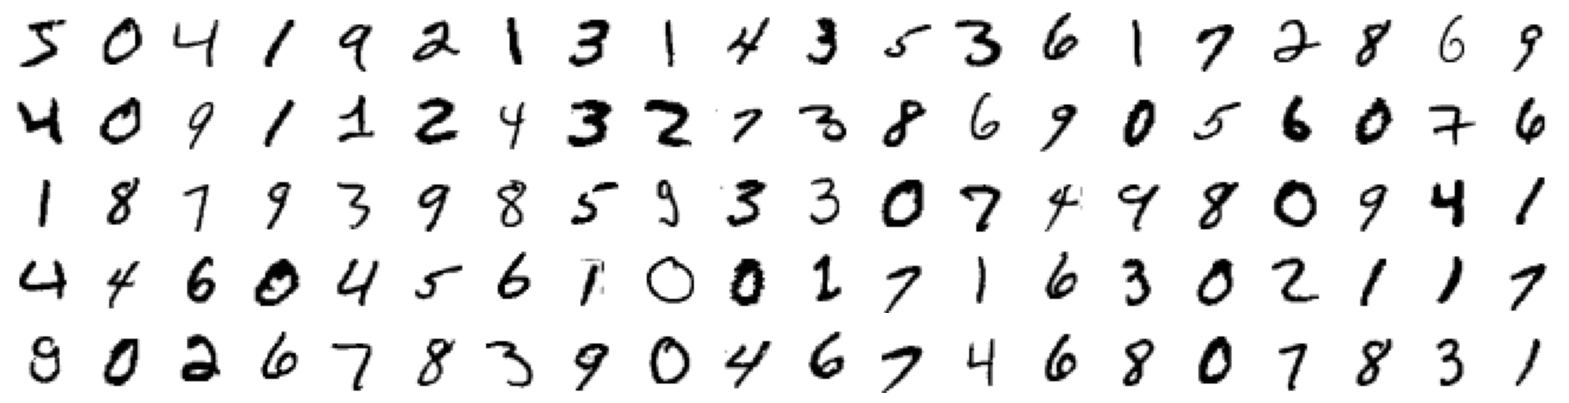

In [7]:
# The first 100 images in the training set in a 5x20 grid
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
for i in range(100):
    plt.subplot(5,20,i+1)
    plt.imshow(x_train[i], cmap="binary")
    plt.axis('off') # Remove the axis
plt.show()


<p>Each of these images is 28x28 pixels, and each pixel is a value between 0 and 255. That means we can think of each image as a sequence of $28 \cdot 28 = 784$ values. We are going start by breaking images into subquences onsisting of the first and second half of each sequence. These will serve as the input sequences and target sequences for our RNN.</p>

In [9]:
# For each image, flatten the 28x28 array into a 784 array, cut it in half. We will use the first half of the sequence
# as an input and the second half as the target.

def flatten_and_sequencify(array) -> list:
    """
    Takes a 2D array of 28x28 pixels, flattens it, and breaks it into pairs of sequences, the first
    392 pixels, and the second 392 pixels. The former will be used as the input, and the latter will be used as the target.

    Args:
        array (list[list[float]]): A 2D array of 28x28 pixels

    Returns:
        list[list[float]]: A list of pairs of sequences, the first 392 pixels, and the second 392 pixels.
    
    Raises:
        ValueError: If the array is not 28x28

    """

    # Import numpy
    import numpy as np

    # Check if the array is 28x28
    if array.shape != (28,28):
        raise ValueError("Array is not 28x28")
    
    # Flatten the array
    flattened = array.flatten()

    # Return the first half of the array and the entire array
    return [flattened[:392], flattened[392:]]

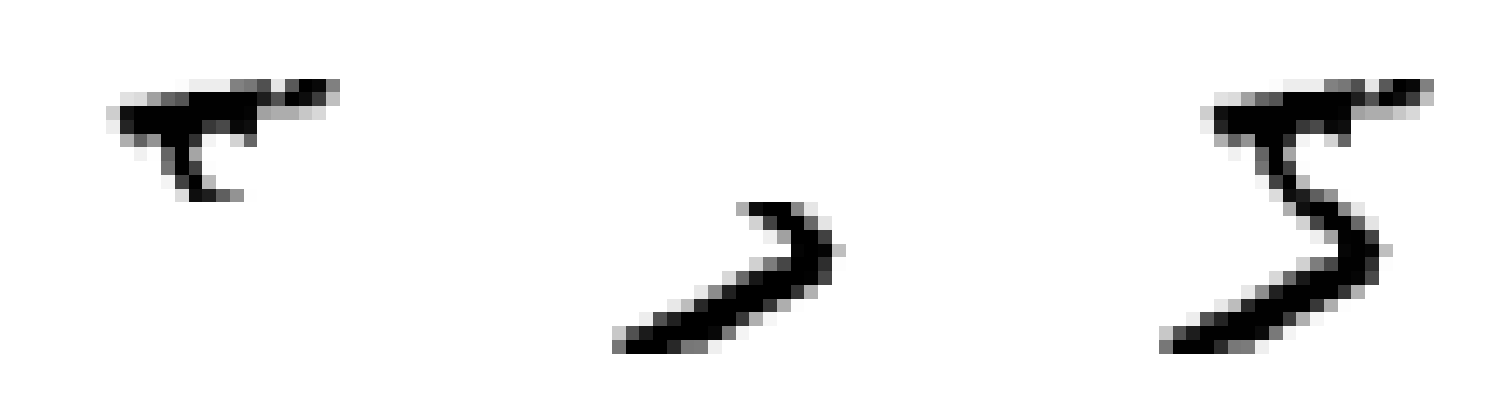

In [10]:
# Let's test the function on the first image in the training set and plot the results
first_image = x_train[0]
first_image_input, first_image_target = flatten_and_sequencify(first_image)

# Let's pad first_image_input with 0s to make it the same length as first_image_target
first_image_input = np.pad(first_image_input, (0, 392), 'constant')

# Now we need to front-pad the target with 0s to make it the same length as the input
first_image_target = np.pad(first_image_target, (392, 0), 'constant')

# Plot the input, target, and the original image
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(first_image_input.reshape(28,28), cmap="binary")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(first_image_target.reshape(28,28), cmap="binary")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(first_image, cmap="binary")
plt.axis('off')
plt.show()

This looks to be functioning according to plan. So let's create our real training set by generating a bunch of sequences of pixels from the MNIST dataset.

In [11]:
# Now, let's do this for all the images in the training set
X_train = []
y_train = []

for image in x_train:
    sequences = flatten_and_sequencify(image)
    X_train.append(sequences[0])
    y_train.append(sequences[1])

# Now, let's do this for all the images in the testing set
X_test = []
y_test = []

for image in x_test:
    sequences = flatten_and_sequencify(image)
    X_test.append(sequences[0])
    y_test.append(sequences[1])

In [13]:
# How many images are in the training set?
print("There are " + str(len(X_train)) + " images in the training set.")

There are 60000 images in the training set.


We now have 60,000 input sequences and 60,000 target sequences to work with for training and validation! Let's see how well we can train a model to predict the next pixel in the sequence. 

In [14]:
# Let's resplit the training set into a training set and a validation set where the validation set is 10% of the training set
X_val = X_train[:6000]
y_val = y_train[:6000]
X_train = X_train[6000:]
y_train = y_train[6000:]

# Let's also convert these lists to a format that tensorflow can understand
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)


In [15]:
def front_pad(image: list, length: int = 392) -> list:
    """
    Takes the last 392 pixels of an image and pads it in front with 0s to make it convertable to a 28x28 array

    Args:
        image (list[float]): A list of 392 pixels
        length (int, optional): The length of the array. Defaults to 392.

    Returns:
        list[float]: A list of 784 pixels
    
    Raises:
        ValueError: If the image is not 392 pixels long
    
    """

    # Check if the image is 392 pixels long
    if len(image) != 392:
        raise ValueError("Image is not 392 pixels long")
    
    # Pad the image with 0s
    padded_image = np.pad(image, (length, 0), 'constant')

    # Return the padded image
    return padded_image

def back_pad(image: list, length: int = 392) -> list:
    """
    Takes the first 392 pixels of an image and pads it in back with 0s to make it convertable to a 28x28 array

    Args:
        image (list[float]): A list of 392 pixels
        length (int, optional): The length of the array. Defaults to 392.

    Returns:
        list[float]: A list of 784 pixels
    
    Raises:
        ValueError: If the image is not 392 pixels long
    
    """

    # Check if the image is 392 pixels long
    if len(image) != 392:
        raise ValueError("Image is not 392 pixels long")
    
    # Pad the image with 0s
    padded_image = np.pad(image, (0, length), 'constant')

    # Return the padded image
    return padded_image

In [16]:
# We also need a function to convert the sequence back to a 28x28 array, so we need to multiply
# each of the values in the sequence by 255 and then reshape it to be a 28x28 array

def convert_sequence_to_array(sequence: list[float]) -> np.ndarray:
    """
    Takes a list of floats and converts it to a 28x28 array

    Args:
        sequence (list[float]): The sequence to convert

    Returns:
        np.ndarray: The 28x28 array

    Raises:
        ValueError: If the length of the sequence is not 784
    """

    # Check if the length of the sequence is not 784
    if len(sequence) != 784:
        raise ValueError("The length of the sequence must be 784")

    # Convert the sequence to an array
    array = np.array(sequence)
    # Multiply each value by 255
    array *= 255
    # Reshape the array to be a 28x28 array
    array = array.reshape(28, 28)

    return array

<h3>Let's see what we need to beat...</h3>
<p>Before we start developing a model, let's take a look at what we need to beat (at the very, VERY least). The simplest prediction that could be made is, of course, that the next pixel in a sequence is the same as the previous pixel, and then we repeat that for the rest of the missing pixels. Let's see how well that works.</p>

In [17]:
# Our fake predictions here will just be the last pixel in the input sequence repeated 392 times
y_pred = np.zeros((10000, 392))
for i in range(10000):
    y_pred[i] = np.array([X_test[i][-1]]*392)

# Let's find the MSE of our fake predictions
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("The MSE of our fake predictions is " + str(mse))

The MSE of our fake predictions is 7894.28274234694


<h2>Time to Train Some Models!</h2>

<p>The time has come to see if we just wasted... our time! We will start with an RNN consisting of a single SimpleRNN layer with a single node. This is unlikely to produce interesting results, as I am pretty sure it will overpenalize deviations from the most recent pixels. In other words, this will either produce a random assemblage of pixels or, more likely a continuous sequence of similiarly colored pixels (assuming I am understanding this correctly; send me a message if not).</p>

In [ ]:
# Model 1: A simple RNN consisting of a single SimpleRNN layer with 1 node. Let's give it a good name.
pixelator = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

# Let's compile the model
pixelator.compile(loss="mse", optimizer="adam")

In [ ]:
# DO NOT RUN THIS CELL UNLESS YOU WANT TO TRAIN THE MODEL

pixelator.fit(X_train.reshape(54000, 392, 1), y_train.reshape(54000, 392, 1), epochs=5, validation_data=(X_val.reshape(6000, 392, 1), y_val.reshape(6000, 392, 1)))

In [ ]:
# Save the model
pixelator.save("pixelator.h5")

<p>This model only predicts the next pixel in the image, so it needs to be applied 392 times to generate a complete image. First we will write a function to iterate through the necessary number of predictions, and then we can plot the results. Let's see how it does (I would not be surprised if it is just a black or white image).</p>

In [87]:
pixelator = keras.models.load_model("models/pixelator.h5")

In [18]:
def generate_image_by_pixel(input_sequence: list[float], model: keras.models.Sequential) -> np.ndarray:
    """
    Generates an image by predicting each pixel in the image one at a time until the image consists of 784 pixels.
    This means that it can take any length of input sequence less than 784 pixels. It will just predict the remaining
    pixels.

    Args:
        input_sequence (list[float]): The input sequence
        model (keras.models.Sequential): The model to use to generate the image

    Returns:
        np.ndarray: The generated image
    
    Raises:
        ValueError: If the length of the input sequence is not greater than 0 and less than 784
        ValueError: If the sequence is not a list of np.uint8

    """

    # Check if the length of the input sequence is not greater than 0 and less than 784
    if len(input_sequence) <= 0 or len(input_sequence) > 784:
        raise ValueError("The length of the input sequence must be greater than 0 and less than 784")
    # Check if the sequence is not a list of floats
    if not all(isinstance(pixel, np.float64) for pixel in input_sequence):
        raise ValueError("The sequence must be a list of floats")
  
    # Convert the input sequence to a format compatible with the model
    input_sequence = input_sequence.reshape(1, len(input_sequence), 1)

    # Predict the remaining pixels, which will be 784 - the size of the second dimension 
    # of the input_sequence
    for i in range(784 - input_sequence.shape[1]):
        prediction = model.predict(input_sequence)
        input_sequence = np.append(input_sequence, prediction[0][0].reshape(1, 1, 1) * 255, axis=1)
    
    array = convert_sequence_to_array(input_sequence.reshape(784))

    # Return the array
    return array

1/1 [==============================] - 0s 31ms/step
(1, 784, 1)
[[[  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
  [  0.        ]
 

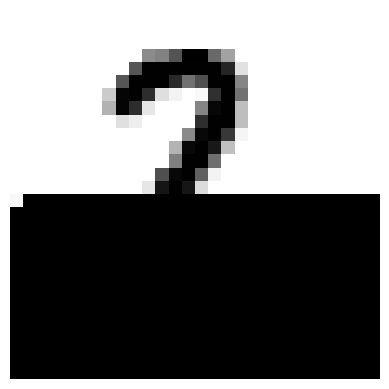

In [215]:
# Test it out on the first 1 image in the test set
import matplotlib.pyplot as plt

image = generate_image_by_pixel(X_test[1].astype(np.float64), pixelator)

plt.imshow(image, cmap="binary")
plt.axis("off")
plt.show()

<h3>I'm shocked! Shocked!... Well not that shocked.</h3>

<p>Hey, what do you know, it created a wall of black pixels! This was a very predictable result (or I made a mistake implementing it somewhere... a very real possibility). I am going to go with the former until someone let's me know where I messed up. Let's see if we can do better with a more complex model.</p>

In [3]:
# Rather than using a single node like last time, let's use a node for each pixel in the image. In addition,
# because these sequences are fairly long, we will use GRU layer instead of a SimpleRNN layer. And just
# for fun, let's add a second GRU layer as a hidden layer. Our output layer will be a TimeDistributed Dense
# layer with 392 nodes and a linear activation function to hopefully give us all 392 missing pixels at once.

# Model 2: A GRU RNN consisting of 2 GRU layers with 392 nodes each and a TimeDistributed Dense layer with 392 nodes
# and a linear activation function
picture_predictor = keras.models.Sequential([
    keras.layers.GRU(392, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(392, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(392, activation="linear"))
])

# Let's compile the model
picture_predictor.compile(loss="mse", optimizer="adam")

2023-06-20 13:44:05.999193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# DO NOT RUN THIS CELL UNLESS YOU WANT TO TRAIN THE MODEL
picture_predictor.fit(X_train.reshape(54000, 392, 1), y_train.reshape(54000, 392, 1), epochs=3, validation_data=(X_val.reshape(6000, 392, 1), y_val.reshape(6000, 392, 1)))

In [4]:
picture_predictor = keras.models.load_model("models/picture_predictor.h5")

It is time to test this thing!

In [24]:
test_prediction = picture_predictor.predict(X_test[1].reshape(1, 392, 1))

print(test_prediction.shape)
print(test_prediction[0].shape)
print(test_prediction[0][0].shape)

1/1 [==============================] - 0s 82ms/step
(1, 392, 392)
(392, 392)
(392,)


<h3>Whoops!</h3>

<p>This did not work out as I had intended. The output ended up being a sequence of 392 sequences. So it produced a sequence
for each of the pixels it was supposed to predict. We still might be able to salvage something from this.

After looking through the sequences produced, I think the values may be the same for all elements of the resultant sequence. So if we just extract the number from anywhere in the sequence use the mean value of the numbers in the sequence, we should get something more like what we are looking for.</p>

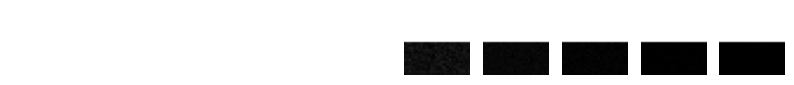

In [28]:
# Let's see what the images from the first few of these sequences look like
fig = plt.figure(figsize=(10, 10))
for i in range(10):
    fig.add_subplot(1, 10, i+1)
    plt.imshow(convert_sequence_to_array(front_pad(test_prediction[0][i])), cmap="binary")
    plt.axis("off")
plt.show()

1/1 [==============================] - 0s 72ms/step


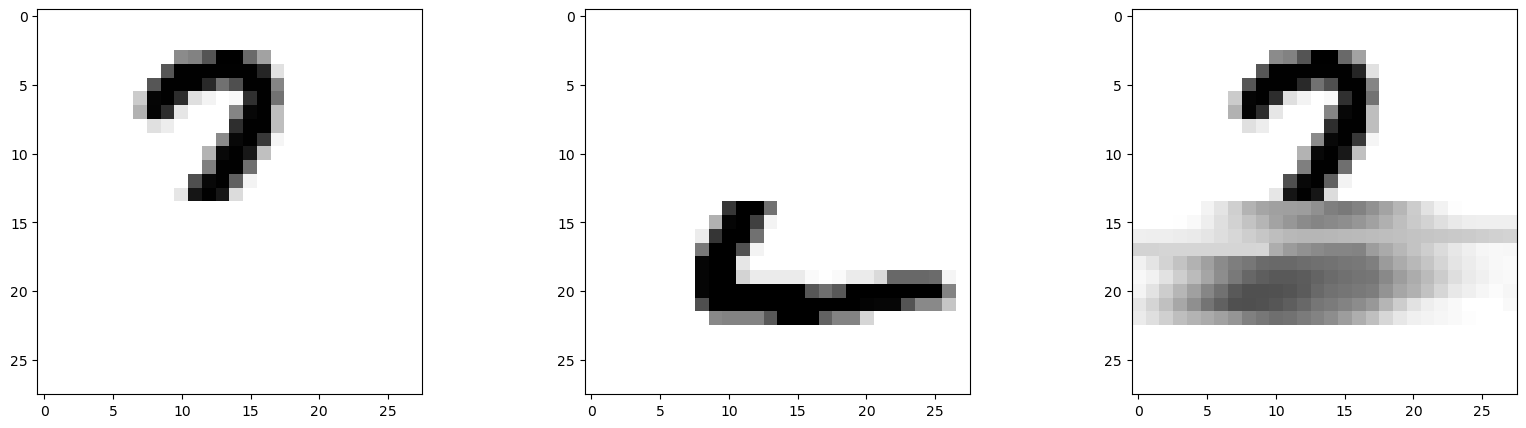

In [31]:
# Let's try to create a picture from the first image in the test set
first_image = X_test[1]
first_image = np.expand_dims(first_image, axis=0)
first_image = np.expand_dims(first_image, axis=-1)

# Let's predict the next 392 pixels
first_image_pred = picture_predictor.predict(first_image)

# Let's plot the input, target, and prediction
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)

# Plot the input, after padding it and converting it to an array
plt.imshow(convert_sequence_to_array(back_pad(255* X_test[1])), cmap="binary")

# Plot the target
plt.subplot(1,3,2)
plt.imshow(convert_sequence_to_array(front_pad(255 * y_test[1])), cmap="binary")

# Now let's try to salvage something from this monstrosity. First we will find the means of all 392 predictions
means = np.mean(first_image_pred[0], axis=1)

# Convert the means to an array that can be plotted
means = np.array(means)

# Combine the input and the means
combined = np.concatenate((X_test[1], means))

# Plot the combined input and means
plt.subplot(1,3,3)
plt.imshow(convert_sequence_to_array(combined), cmap="binary")

plt.show()



That is certainly more interesting that the result of the first model. Let's see how some of the other images look.

1/1 [==============================] - 0s 66ms/step


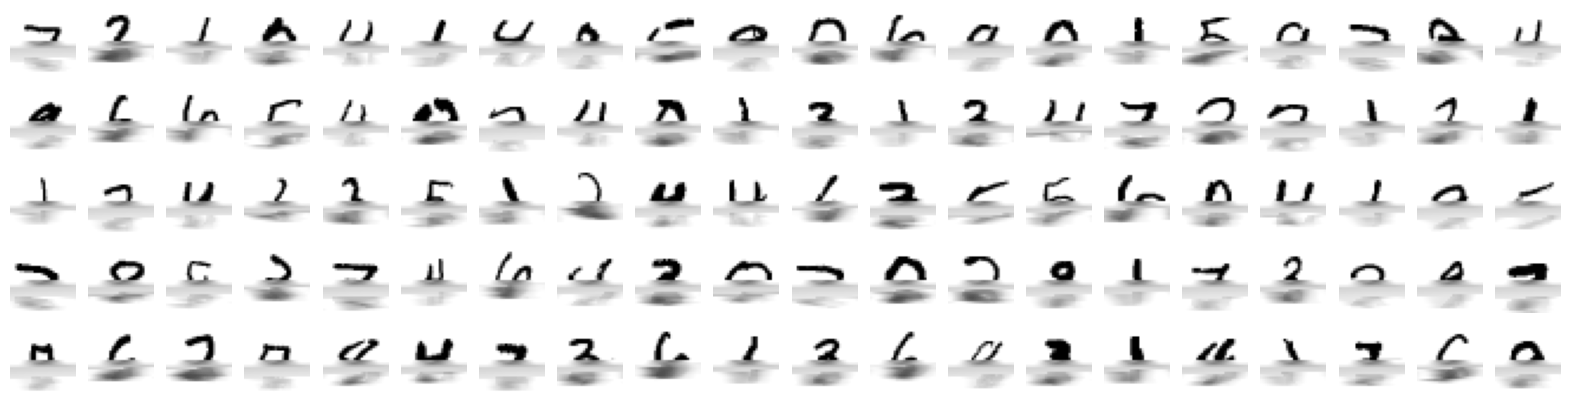

In [33]:
# Let's repeat the process for the first 100 images in the test set, and plot the results in a 5x20 grid
fig = plt.figure(figsize=(20, 5))
for i in range(100):
    # Get the image
    image = X_test[i]
    # Expand the dimensions of the image
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=-1)
    # Predict the next 392 pixels
    image_pred = picture_predictor.predict(image)
    # Find the means of all 392 predictions
    means = np.mean(image_pred[0], axis=1)
    # Convert the means to an array that can be plotted
    means = np.array(means)
    # Combine the input and the means
    combined = np.concatenate((X_test[i], means))
   
    # Plot the input, target, and prediction
    plt.subplot(5, 20, i+1)
    plt.imshow(convert_sequence_to_array(combined), cmap="binary")
    plt.axis("off")

plt.show()

<h3>Well, that's some improvement!</h3>

<p>It looks like the model was more effective on digits with lesser complexity. The sixes, in particular, look vaguely like sixes. LMAO. I am going to retry this with a similar model, but that only produces the sequence of pixels for the second half of the image (instead of a sequence for each pixel). This should be less messy to deal with.</p>

In [34]:
# We will use a similar model as before, this time using 2 LSTM layers instead of 2 GRU layers. The output layer
# will be the biggest difference. This time we will just use a Dense layer with a single node. I think this will
# produce something similar to what we got with the GRU model, but without having to go through the extra step of
# finding the means of the predictions to get the final image.

mnist_finisher = keras.models.Sequential([
    keras.layers.LSTM(392, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(392, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation="relu"),
])

mnist_finisher.compile(loss="mse", optimizer="adam")

In [ ]:
# DO NOT RUN THIS CELL UNLESS YOU WANT TO TRAIN THE MODEL
mnist_finisher.fit(X_train.reshape(54000, 392, 1), y_train.reshape(54000, 392, 1), epochs=3, validation_data=(X_val.reshape(6000, 392, 1), y_val.reshape(6000, 392, 1)))

<p>Moment of truth...</p>

1/1 [==============================] - 0s 86ms/step


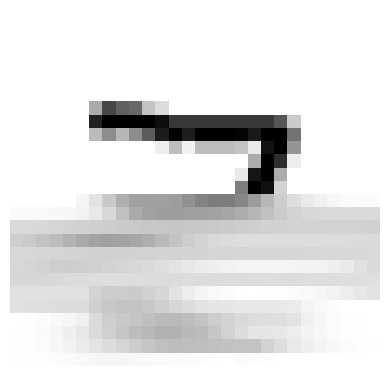

In [42]:
next_image = X_test[0]
next_image = np.expand_dims(next_image, axis=0)
next_image = np.expand_dims(next_image, axis=-1)

# Let's predict the next 392 pixels
next_image_pred = mnist_finisher.predict(next_image)

# Convert the prediction to an array that can be plotted
next_image_pred = np.array(next_image_pred)

# Combine the input and the prediction
combined = np.concatenate((X_test[0], next_image_pred[0].ravel()))

# Plot the combined input and prediction
plt.imshow(convert_sequence_to_array(combined), cmap="binary")
plt.axis("off")
plt.show()


1/1 [==============================] - 0s 79ms/step


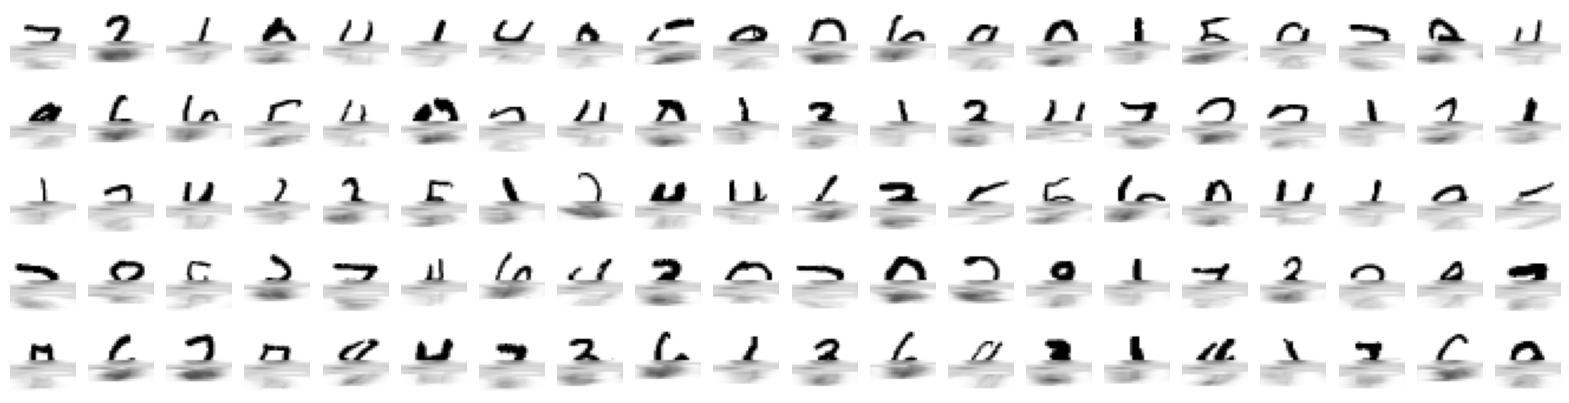

In [38]:
# Plot the first 100 images in the test set, combined with the prediction for the next 392 pixels
# in a 5x20 grid
fig = plt.figure(figsize=(20, 5))
for i in range(100):
    # Get the image
    image = X_test[i]
    # Expand the dimensions of the image
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=-1)
    # Predict the next 392 pixels
    image_pred = mnist_finisher.predict(image)
    # Convert the prediction to an array that can be plotted
    image_pred = np.array(image_pred)
    # Combine the input and the prediction
    combined = np.concatenate((X_test[i], image_pred[0].ravel()))
   
    # Plot the input, target, and prediction
    plt.subplot(5, 20, i+1)
    plt.imshow(convert_sequence_to_array(combined), cmap="binary")
    plt.axis("off")

plt.show()

<p>That looks pretty much identical to what we got from the previous model! I am going to try a few more things before moving on to the GAN (which I would consider the more appropriate method for this task). First I am going to try a model with a single LSTM layer instead of a SimpleRNN layer. I am not sure if this will make a difference, but it could be fun!</p>

In [43]:
# This model will be just a single LSTM layer, with a single node in the output layer. 

mnist_finisher_2 = keras.models.Sequential([
    keras.layers.LSTM(392, return_sequences=True, input_shape=[None, 1]),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation="relu"),
])

mnist_finisher_2.compile(loss="mse", optimizer="adam")


In [44]:
# DO NOT RUN THIS CELL UNLESS YOU WANT TO TRAIN THE MODEL
mnist_finisher_2.fit(X_train.reshape(54000, 392, 1), y_train.reshape(54000, 392, 1), epochs=3, validation_data=(X_val.reshape(6000, 392, 1), y_val.reshape(6000, 392, 1)))

Epoch 1/3
1688/1688 [==============================] - 1456s 862ms/step - loss: 5432.8267 - val_loss: 4826.5288
Epoch 2/3
1688/1688 [==============================] - 1355s 803ms/step - loss: 4558.2500 - val_loss: 4470.1118
Epoch 3/3
1688/1688 [==============================] - 1368s 811ms/step - loss: 4751.2056 - val_loss: 4617.0312


1/1 [==============================] - 0s 341ms/step


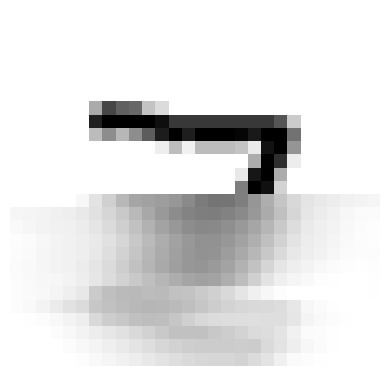

In [45]:
# Let's try it out!
next_image = X_test[0]
next_image = np.expand_dims(next_image, axis=0)
next_image = np.expand_dims(next_image, axis=-1)

# Let's predict the next 392 pixels
next_image_pred = mnist_finisher_2.predict(next_image)

# Convert the prediction to an array that can be plotted
next_image_pred = np.array(next_image_pred)

# Combine the input and the prediction
combined = np.concatenate((X_test[0], next_image_pred[0].ravel()))

# Plot the combined input and prediction
plt.imshow(convert_sequence_to_array(combined), cmap="binary")
plt.axis("off")
plt.show()


<p>That looks pretty similar to what we had from the previous one, and this trained much more quickly. Let's look at some of the other images so we can make a larger comparison.</p>

1/1 [==============================] - 0s 51ms/step


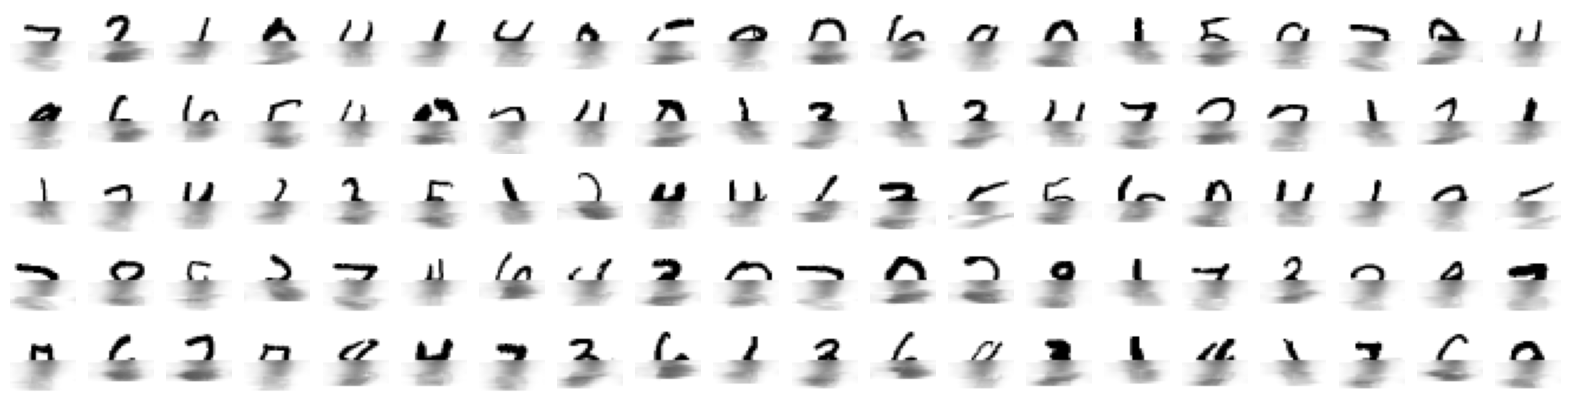

In [46]:
# Plot the first 100 images in the test set, combined with the prediction for the next 392 pixels
# in a 5x20 grid
fig = plt.figure(figsize=(20, 5))
for i in range(100):
    # Get the image
    image = X_test[i]
    # Expand the dimensions of the image
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=-1)
    # Predict the next 392 pixels
    image_pred = mnist_finisher_2.predict(image)
    # Convert the prediction to an array that can be plotted
    image_pred = np.array(image_pred)
    # Combine the input and the prediction
    combined = np.concatenate((X_test[i], image_pred[0].ravel()))
   
    # Plot the input, target, and prediction
    plt.subplot(5, 20, i+1)
    plt.imshow(convert_sequence_to_array(combined), cmap="binary")
    plt.axis("off")

plt.show()


<p>It's a little difficult to compare this way, so we will plot the images side-by-side with the original image and the images produced using the last model. We will make a function to do this for us.</p>

In [161]:
def image_comparison(input_sequence: list[int], output_sequence: list[int], models = list[keras.models.Model]) -> None:
    """
    Uses each of the models in the list to predict the rest of the image represented by input_sequence, then plots
    the images produced by each model in a row.

    Args:
        input_sequence (list[int]): The first 392 pixels of the image to be predicted.
        output_sequence (list[int]): The rest of the image to be predicted.
        models (list[keras.models.Model]): A list of models to use to predict the rest of the image.
    
    Raises:
        ValueError: If the length of input_sequence is not 392.

    """

    # Check that the length of input_sequence is 392
    if len(input_sequence) != 392:
        raise ValueError("The length of input_sequence must be 392.")
    
    # Use a variable to sore the input sequence that can be modified
    input_sequence_rf = input_sequence

    # Convert the input sequence to an array that can be used by the models
    input_sequence_rf = np.array(input_sequence_rf)
    input_sequence_rf = np.expand_dims(input_sequence_rf, axis=0)
    input_sequence_rf = np.expand_dims(input_sequence_rf, axis=-1)

    # Predict the rest of the image for each model
    predictions = []
    for model in models:
        predictions.append(model.predict(input_sequence_rf))
        
    # Combine the input and the predictions
    combinations = []

    for prediction in predictions:
        combinations.append(np.concatenate((input_sequence, prediction.ravel())))

    print(np.concatenate((input_sequence, output_sequence)).shape)

    # Plot the original image, and the input_sequence concatenated with each of the predictions
    fig = plt.figure(figsize=(5,10))
    plt.subplot(1, len(models)+1, 1)
    plt.imshow(convert_sequence_to_array(255*np.concatenate((input_sequence, output_sequence))), cmap="binary")
    plt.title("Original Image")
    plt.axis("off")

    for i in range(len(models)):
        plt.subplot(1, len(models)+1, i+2)
        plt.imshow(convert_sequence_to_array(combinations[i]), cmap="binary")
        plt.title("Model " + str(i+1))
        plt.axis("off")

    plt.show()

1/1 [==============================] - 0s 50ms/step
(784,)


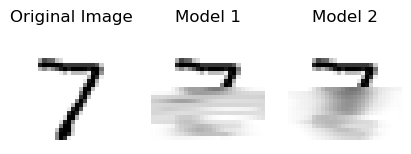

1/1 [==============================] - 0s 50ms/step
(784,)


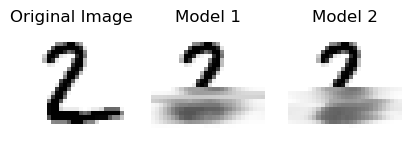

1/1 [==============================] - 0s 52ms/step
(784,)


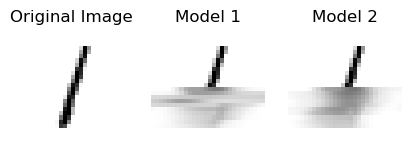

1/1 [==============================] - 0s 52ms/step
(784,)


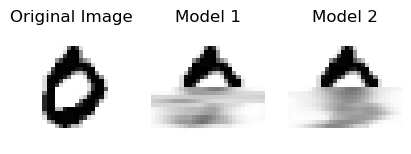

1/1 [==============================] - 0s 51ms/step
(784,)


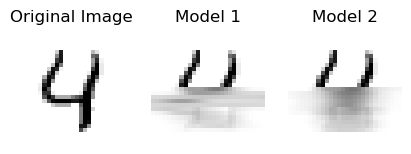

1/1 [==============================] - 0s 50ms/step
(784,)


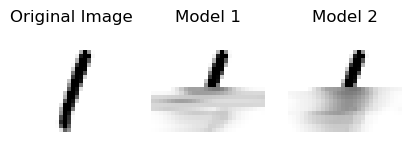

1/1 [==============================] - 0s 50ms/step
(784,)


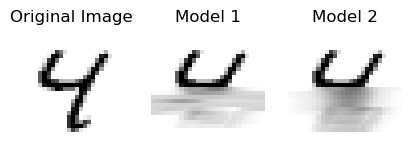

1/1 [==============================] - 0s 50ms/step
(784,)


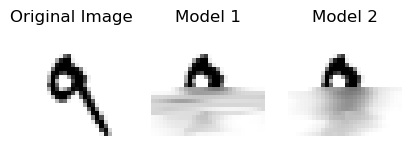

1/1 [==============================] - 0s 50ms/step
(784,)


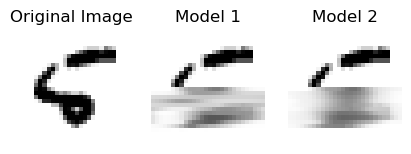

1/1 [==============================] - 0s 50ms/step
(784,)


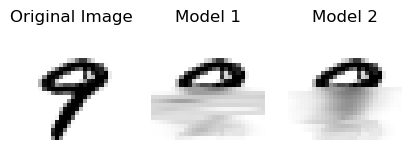

In [162]:
# Let's compare the original images to the results for the mnist_finisher and the mnist_finisher_2
# for the first 10 images in the test set
for i in range(10):
    image_comparison(X_test[i], y_test[i], [mnist_finisher, mnist_finisher_2])

<p>Okay. Last one before we move on to the GAN. I promise. This time, why don't we try to simplify our lives by keeping the images in their original form and using the first 14 rows (with their corresponding 28 columns) to predict the last 14 rows. This should be a little easier to deal with since there are fewer modifications to make to the data along the way. Let's also pretend like we actually want this to work this time around.</p>

In [193]:
# Our final RNN approach will use a sequence-to-sequence model. This model will take in the first 14 rows of an image
# and output the last 14 rows of the image. We will use a modification of our previous models. We are still going to use
# two LSTM layers, one as the input (this time with a shape of 14 x 28) and another as a hidden layer, but we will use a 
# RepeatVector layer to repeat the output of the LSTM layer 14 times so that the second LSTM layer can process with added
# context. We will then use a TimeDistributed layer to apply a Dense layer to each of the 14 vectors. 

# Here is our model architecture:
mnist_finisher_1000 = keras.models.Sequential([
    keras.layers.LSTM(128, input_shape=[14, 28]),
    keras.layers.RepeatVector(14),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])

# Let's compile the model
mnist_finisher_1000.compile(loss="binary_crossentropy", optimizer="adam")

In [194]:
# I'm going to reimport the data since I can't remember what I did to it
(X_train, _), (X_test, _) = mnist.load_data()

# Let's normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Now we will separate the first and second halves of the images
y_train = X_train[:, 14:, :]
X_train = X_train[:, :14, :]

y_test = X_test[:, 14:, :]
X_test = X_test[:, :14, :]

# I think we will do a few more epochs this time around
mnist_finisher_1000.fit(X_train, y_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 18s 33ms/step - loss: 0.2720
Epoch 2/10
469/469 [==============================] - 15s 32ms/step - loss: 0.2163
Epoch 3/10
469/469 [==============================] - 15s 32ms/step - loss: 0.1971
Epoch 4/10
469/469 [==============================] - 15s 32ms/step - loss: 0.1874
Epoch 5/10
469/469 [==============================] - 15s 33ms/step - loss: 0.1812
Epoch 6/10
469/469 [==============================] - 15s 32ms/step - loss: 0.1761
Epoch 7/10
469/469 [==============================] - 15s 32ms/step - loss: 0.1726
Epoch 8/10
469/469 [==============================] - 15s 33ms/step - loss: 0.1696
Epoch 9/10
469/469 [==============================] - 15s 32ms/step - loss: 0.1674
Epoch 10/10
469/469 [==============================] - 16s 34ms/step - loss: 0.1653


1/1 [==============================] - 0s 19ms/step


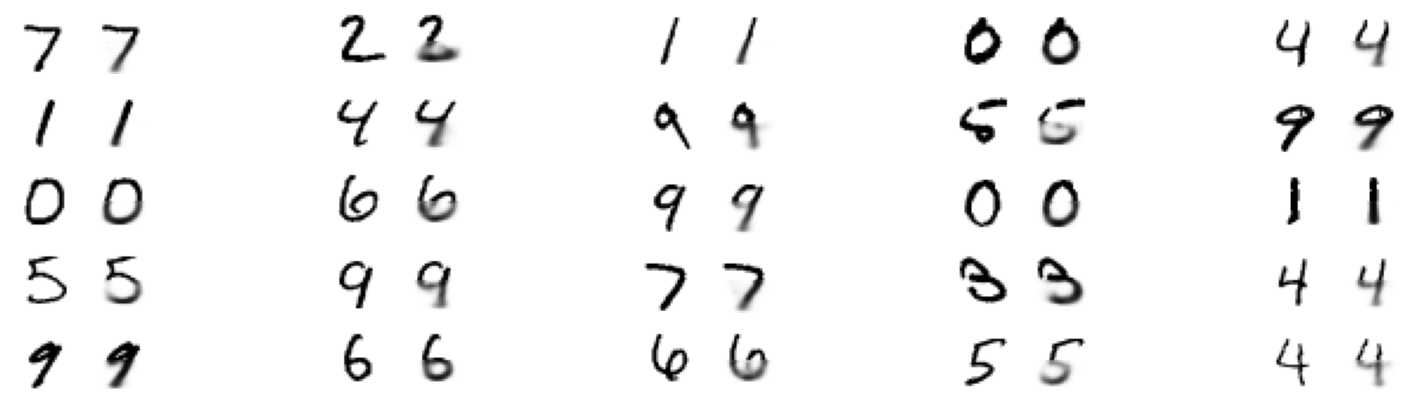

In [215]:
# Let's see how it does on the first 25 images in the test set compared to the originals and put them in 5 rows
#  consisting of 4 images each, where the original is on the left, and the generated image is on the right. 
fig = plt.figure(figsize=(20,5))
for i in range(25):
    # First we plot the original image (i.e., X_test[i] concatenated with y_test[i])
    plt.subplot(5, 20, 4*i + 1)
    plt.imshow(255*tf.concat([X_test[i], y_test[i]], axis=0), cmap="binary")
    plt.axis("off")

    # Generate the second half of an image
    input_image = X_test[i:i+1]
    generated_second_half = mnist_finisher_1000.predict(input_image)

    # Now we need to concatenate the input image with the generated second half and place it next to the original image
    plt.subplot(5, 20, 4*i + 2)

    # Display the generated second half
    generated_image = tf.concat([input_image[0], generated_second_half[0]], axis=0)
    plt.imshow(255*generated_image, cmap="binary")
    plt.axis("off")

plt.show()


<p>That actually worked quite a bit better than I was expecting. Nice! Now onto what I would consider the more obvious approach to this problem: a GAN.</p>

<h2>Let's try this with a GAN!</h2>

<p>From the beginning, I have known that a GAN would be a better approach to this problem. Let's get to it!</p>